# Vignette Notebook: How to call IBD with ancIBD
This notebook walks you through the steps to call IBD segments with `ancIBD`.
It assumes one has data in hdf5 format, including genetic map and ideally also allele frequency data. For how to produce such a .hdf5 file from an imputed VCF, please see the vignette notebook `create_hdf5_from_vcf.ipynb`

In [1]:
import sys as sys
import matplotlib.cm as cm
import pandas as pd
import os as os

### The following code gives nice and clean Arial font on your plots
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

### Set working directory to your vignette folder
###
# Edit the  following path for your folder
path = "/n/groups/reich/hringbauer/git/hapBLOCK/notebook/vignette/"

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())
###

### The following Code sets the working directory to your ancIBD code
#sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/python3/") # Path to Development Version
sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/package/ancIBD/")  # hack to get development package first in path

/n/groups/reich/hringbauer/git/hapBLOCK/notebook/vignette


# Code to run IBD calling
Note: For a quick test run for a pairs of indivdiuals and a specific chromosome including a visualization of the posterior, see the vignette notebook `./plot_IBD.ipynb`. This visual test is always recommended to verify whether your data is sound and everything works as expected.

Here, the walk-through is through the calling of IBD in a full data set including multiple individuals and chromosomes.

In [2]:
from run import hapBLOCK_chroms

ModuleNotFoundError: No module named 'cfunc'

### Specify list of Indivdiuals
Remember: ancIBD is data-hungry, and only works for sample with at least 600,000 1240k SNPs covered. If you run it for indivdiuals with fewer SNPs, you will receive output, **but that output is not trustworthy**, with little power to call IBD and high false positive rates.

In [4]:
iids = ["I12439", "I12440", "I12438", 
        "I12896", "I21390", "I30300"] # The six Hazelton Indivdiuals of the example data.

### This is the main IBD calling
The function `hapBLOCK_chroms` calls IBD of an input hdf5. It outputs a dataframe of IBD, which below the function is saved into a specified output folder.

These are the main parameters
- folder_in: The path of the hdf5 files used for IBD calling. The format is so that everything up to the chrosome number is specified.
- iids: All iids to load from the hdf
- run_iids: Which pairs to run [[iid1, iid2], ...] If this parameter is left empty, then all pairs are run.

The parameters specifiying the various modes of 'ancIBD', and the parameters are default values. E.g. ibd_in, ibd_out, ibd_jump control the jump rates of the underlying HMM (in rates per Morgan). Power users can modify those, but the default values are the recommend parameters for default human data.

In [8]:
%%time

for ch in range(22,23):
    df_ibd = hapBLOCK_chroms(folder_in='./data/hdf5/example_hazelton_chr',
                             iids=iids, run_iids=[],
                             ch=ch, folder_out='./output/ibd_hazelton/',
                             output=False, prefix_out='', logfile=False,
                             l_model='hdf5', e_model='haploid_gl', h_model='FiveStateScaled', t_model='standard',
                             ibd_in=1, ibd_out=10, ibd_jump=400,
                             min_cm=6, cutoff_post=0.99, max_gap=0.0075,
                             processes=1)

CPU times: user 304 ms, sys: 11.2 ms, total: 315 ms
Wall time: 331 ms


# Area 51

In [4]:
from run import run_plot_pair

Filtering to 0.99 GP variants: 0.966x
Filtering to 0.99 GP variants: 0.875x
Filtering to common GP variants: 0.861x
Plotting 15483 markers


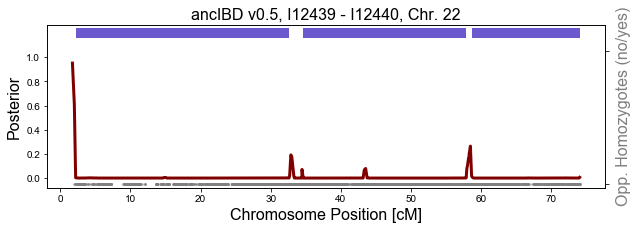

In [8]:
iids = ["I12439", "I12440"]	

run_plot_pair(iids=iids, ch=22, plot=True, xlim=[],
              path_h5 = "/n/groups/reich/hringbauer/git/hapBLOCK/notebook/vignette/data/hdf5/example_hazelton_chr" ,
              min_cm=6, p_col='', ms=1.5,
              path_fig="", fs_l=16, figsize=(10,3))

Filtering to 0.99 GP variants: 0.966x
Filtering to 0.99 GP variants: 0.875x
Filtering to common GP variants: 0.861x
Plotting 15483 markers


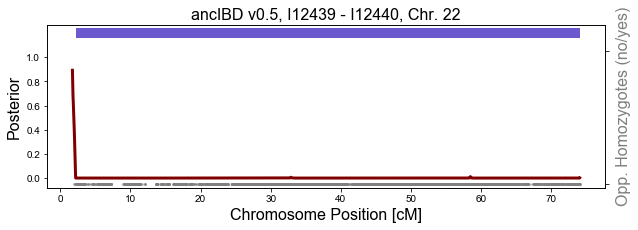

In [11]:
iids = ["I12439", "I12440"]	

run_plot_pair(iids=iids, ch=22, plot=True, xlim=[],
              path_h5 = "/n/groups/reich/hringbauer/git/hapBLOCK/notebook/vignette/data/hdf5/example_hazelton_chr",
              min_cm=6, p_col='variants/AF_ALL', ms=1.5,
              path_fig="", fs_l=16, figsize=(10,3))

Filtering to 0.99 GP variants: 0.966x
Filtering to 0.99 GP variants: 0.875x
Filtering to common GP variants: 0.861x
Plotting 15483 markers


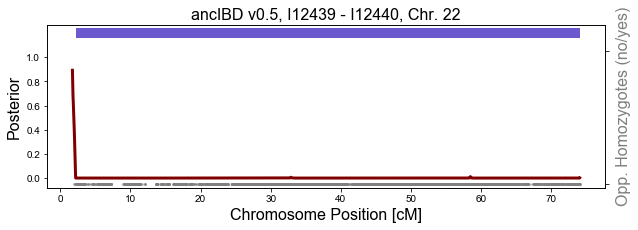

In [9]:
iids = ["I12439", "I12440"]	

run_plot_pair(iids=iids, ch=22, plot=True, xlim=[],
              path_h5 = "/n/groups/reich/hringbauer/git/hapBLOCK/data/hdf5/1240k_v51.1/ch" ,
              min_cm=6, p_col='variants/AF_ALL', ms=1.5,
              path_fig="", fs_l=16, figsize=(10,3))